In [1]:
from IPython.core.display import display, HTML
#display(HTML('<style>.container {width:100% !important;} <\style>'))

In [2]:
import sys
sys.path.insert(0,'../..') # Sett inn det som trengs for at numerical_integrators
                           # blir tilgjengelig i path

In [3]:
from numerical_integrators.singlestep import rk2, rk3, rk4
from numerical_integrators.adaptive_step import rkdp54,rkdp87

In [4]:
import multiprocessing as mp
import numpy as np
from numba import njit
from scipy.interpolate import splprep as scp_splprep,\
                              splev as scp_splev
import time

In [5]:
import matplotlib as mpl
mpl.use("pgf")

#################################################
##### Fjern kommentarer for bonus-stilpoeng #####
#################################################

# Custom matplotlib config (fonts etc)

## TeX preamble
#pgf_with_pdflatex = {
#    "font.family": "serif",
#    "text.usetex": True,
#    "text.latex.unicode": True,
#    "pgf.texsystem": "pdflatex",
#    "pgf.preamble": [
#         r"\usepackage[utf8x]{inputenc}",
#         r"\usepackage[T1]{fontenc}",
#         r"\usepackage[]{libertine}"
#         r"\usepackage[libertine]{newtxmath}"
#         ]
#}
#mpl.rcParams.update(pgf_with_pdflatex)


#mpl.rcParams['font.family'] = 'Libertine'

#from matplotlib import rc
#rc('font', **{'family': 'serif', 'serif': ['Linux Libertine']})

#import matplotlib.font_manager as fm
#prop = fm.FontProperties(fname='/usr/local/texlive/2017/texmf-dist/fonts/opentype/public/libertine/LinLibertine_DR.otf')

from matplotlib import pyplot as plt
#plt.rc('text',usetex=True)
plt.rc('figure',figsize=(5.05,3.1),dpi=100)
#plt.rc('text.latex',preamble=[r'\usepackage[]{libertine}',r'\usepackage[libertine]{newtxmath}'])
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

In [6]:
def f(t,x,A=1,B=1,C=1):
    """
    param: t -- Time
    param: x -- Twelve-component (NumPy) array, containing the flow map and Jacobian at time t. 
                Shape: (12,nx,ny,nz)
    
    return: Twelve-component array, containing the (component-wise) right hand side of the
            coupled equation of variations
            Shape: (12,nx,ny,nz)
    """
    ret     = np.empty(x.shape)
    ret[0]  = A*np.sin(x[2]) + C*np.cos(x[1])                # x-component of velocity field
    ret[1]  = B*np.sin(x[0]) + A*np.cos(x[2])                # y-component of velocity field
    ret[2]  = C*np.sin(x[1]) + B*np.cos(x[0])                # z-component of velocity field
    ret[3]  = -C*np.sin(x[1])*x[6] + A*np.cos(x[2])*x[9]     # The remaining (coupled) entries 
    ret[4]  = -C*np.sin(x[1])*x[7] + A*np.cos(x[2])*x[10]    # constitute the RHS of the 
    ret[5]  = -C*np.sin(x[1])*x[8] + A*np.cos(x[2])*x[11]    # variational ODE for the 
    ret[6]  = B*np.cos(x[0])*x[3] + -A*np.sin(x[2])*x[9]     # flow map Jacobian
    ret[7]  = B*np.cos(x[0])*x[4] + -A*np.sin(x[2])*x[10]
    ret[8]  = B*np.cos(x[0])*x[5] + -A*np.sin(x[2])*x[11]
    ret[9]  = -B*np.sin(x[0])*x[3] + C*np.cos(x[1])*x[6]
    ret[10] = -B*np.sin(x[0])*x[4] + C*np.cos(x[1])*x[7]
    ret[11] = -B*np.sin(x[0])*x[5] + C*np.cos(x[1])*x[8]
    return ret

def compute_strain_eigenvalues_and_vectors(t0,x,y,z,tf,h,func,integ,nproc=4):
    jac = find_endpoint_jacobian(t0,x,y,z,tf,h,func,integ,nproc)
    u,s,v = np.linalg.svd(jac)
    
    lm1 = s[...,2]**2
    lm2 = s[...,1]**2
    lm3 = s[...,0]**2
    
    xi1 = v[...,2]
    xi2 = v[...,1]
    xi3 = v[...,0]
    
    return (lm1, lm2, lm3), (xi1, xi2, xi3)
    
def find_endpoint_jacobian(t0,x,y,z,tf,h,func,integ,nproc):
    grid = np.zeros((12,x.shape[0],y.shape[0],z.shape[0]))
    grid[:3] = np.array(np.meshgrid(x,y,z,indexing='ij'))    # Initial conditions (to be advected)
    grid[3]  = 1                                             # Initial condition for the flow map Jacobian: 
    grid[7]  = 1                                             #     Identity matrices
    grid[11] = 1
    
    # Divide the advection across the no. of available processor cores
    div = np.ceil(np.linspace(0,x.shape[0],nproc+1)).astype(int) 
    
    # Initialize queues and processes for multiprocessing
    qs = [mp.Queue() for j in range(nproc)]
    ps = [mp.Process(target=_advect_slice,
                     args=(t0,grid[:,div[j]:div[j+1]],tf,h,func,integ,qs[j]))
          for j in range(nproc)]
    
    # Initiate subprocesses
    [p.start() for p in ps]
    # Gather results
    for j, q in enumerate(qs):
        grid[:,div[j]:div[j+1]] = q.get()
    # Enforce termination of each process
    [p.join() for p in ps]
    
    # Return only the Jacobian, reshaped for later convenience
    return grid[3:].transpose(1,2,3,0).reshape((x.shape[0],y.shape[0],z.shape[0],3,3))

def _advect_slice(t0,pos,tf,h,func,integ,q):
    if integ == rk4:
        t = t0
        for j in range(np.ceil((tf-t0)/h).astype(int)):
            t,pos,h = integ(t,pos,h,func)
        q.put(pos)
    elif integ == rkdp87:
        t = np.ones(pos.shape[1:])*t0
        h = np.ones(pos.shape[1:])*h
        while np.any(t<tf):
            h = np.minimum(h,tf-t)
            t,pos,h = integ(t,pos,h,func)
        q.put(pos)
    else:
        raise RuntimeError('Integrator configuration not loaded!')

In [7]:
# Advection parameters
t0 = 0
tf = 1
h = 0.1
flowmap_integrator = rkdp87

# Grid parameters
xmin = 0
xmax = 2*np.pi
ymin = 0
ymax = 2*np.pi
zmin = 0
zmax = 2*np.pi

nx = 101
ny = 102
nz = 103

x,dx = np.linspace(xmin,xmax,nx,retstep=True)
y,dy = np.linspace(ymin,ymax,ny,retstep=True)
z,dz = np.linspace(zmin,zmax,nz,retstep=True)

In [8]:
# Compute eigenvalues and -vectors of the Cauchy-Green strain tensor:

(lm1,lm2,lm3),(xi1,xi2,xi3) = compute_strain_eigenvalues_and_vectors(t0,x,y,z,tf,h,f,flowmap_integrator)

In [9]:
# Compute Hessian efficiently by making use of NumPy's gradient function
def compute_hessian_lm(lm,dx,dy,dz):
    grad = np.gradient(lm,dx,dy,dz,edge_order=2)
    hessian = np.empty((x.shape[0],y.shape[0],z.shape[0],3,3))
    for k, grad_k in enumerate(grad):
        # Iterate over the number of dimensions
        # Apply gradient operator to each component of the first derivative
        tmp_grad = np.gradient(grad_k,dx,dy,dz,edge_order=2)
        for l, grad_kl in enumerate(tmp_grad):
            hessian[...,k,l] = grad_kl
    return hessian

In [10]:
# Compute AB subdomain
def find_points_in_ab(hess_lm3,lm3,lm2,xi3):
    mask_a = np.logical_and(np.greater(lm3,1),np.greater(lm3,lm2))
    mask_b = np.less_equal(np.sum(xi3*np.sum(hess_lm3*xi3[...,np.newaxis],axis=3),axis=3),0)
    return np.logical_and(mask_a,mask_b)

In [11]:
# Currently not used - kept for future reference wrt parameters etc
#hlm3 = compute_hessian_lm(lm3,x,y,z)
#mask_ab = find_points_in_ab(hlm3,lm3,lm2,xi3)

In [56]:
# Porting a point version of the Dormand-Prince 5(4) integrator,
# tailor-made to take an integration step in all or none
# of its components, in order to compute three-dimensional
# trajectories
def dp54_p(t,x,h,f,atol=1e-6,rtol=1e-9,**kwargs):
    # Safety factors for the timestep update
    fac = 0.8
    maxfac = 2.
    
    t = np.ones(x.shape)*t
    h = np.ones(x.shape)*h
    
    # Nodes
    c2 = 1./5.
    c3 = 3./10.
    c4 = 4./5.
    c5 = 8./9.
    c6 = 1.
    c7 = 1.
    
    # Matrix elements
    
    a21 = 1./5.
    a31 = 3./40.                                                                
    a32 = 9./40.                                                                
    a41 = 44./45.                                                               
    a42 = -56./15.                                                              
    a43 = 32./9.                                                                
    a51 = 19372./6561.                                                          
    a52 = -25360./2187.                                                         
    a53 = 64448./6561.                                                          
    a54 = -212./729.                                                            
    a61 = 9017./3168.                                                           
    a62 = -355./33.                                                             
    a63 = 46732./5247.                                                          
    a64 = 49./176.                                                              
    a65 = -5103./18656.                                                         
    a71 = 35./384.                                                              
    a72 = 0.                                                                    
    a73 = 500./1113.                                                            
    a74 = 125./192.                                                             
    a75 = -2187./6784.                                                          
    a76 = 11./84.
    
    # Fourth-order weights                                                      
    b41 = 5179./57600.                                                          
    b42 = 0.                                                                    
    b43 = 7571./16695.                                                          
    b44 = 393./640.                                                             
    b45 = -92097./339200.                                                       
    b46 = 187./2100.                                                            
    b47 = 1./40.                                                                
                                                                                
    # Fifth-order weights                                                       
    b51 = 35./384.                                                              
    b52 = 0.                                                                    
    b53 = 500./1113.                                                            
    b54 = 125./192.                                                             
    b55 = -2187./6784.                                                          
    b56 = 11./84.                                                               
    b57 = 0.
    
    # Find "slopes"
    k1 = f(t       , x                                               , **kwargs)
    k2 = f(t + c2*h, x + a21*h*k1                                    , **kwargs)
    k3 = f(t + c3*h, x + a31*h*k1 + a32*h*k2                         , **kwargs)
    k4 = f(t + c4*h, x + a41*h*k1 + a42*h*k2 + a43*h*k3              , **kwargs)
    k5 = f(t + c5*h, x + a51*h*k1 + a52*h*k2 + a53*h*k3 + a54*h*k4   , **kwargs)
    k6 = f(t + c6*h, x + a61*h*k1 + a62*h*k2 + a63*h*k3 + a64*h*k4              
                                                + a65*h*k5           , **kwargs)
    k7 = f(t + c7*h, x + a71*h*k1 + a72*h*k2 + a73*h*k3 + a74*h*k4              
                                                + a75*h*k5 + a76*h*k6, **kwargs)
                                                                                
    # Find fourth and fifth order prediction of new point                       
    x_4 = x + h*(b41*k1 + b42*k2 + b43*k3 + b44*k4 + b45*k5 + b46*k6 + b47*k7)  
    x_5 = x + h*(b51*k1 + b52*k2 + b53*k3 + b54*k4 + b55*k5 + b56*k6 + b57*k7)
    
    # Implementing error check and variable stepsize roughly as in              
    # Hairer, Nørsett and Wanner: "Solving ordinary differential                
    #                              equations I -- Nonstiff problems",           
    #                              pages 167 and 168 in the 2008 ed.  
    
    # The method is 5th order, with 4th order interpolation, hence:
    q = 4.
    
    sc = atol + np.maximum(np.abs(x_4), np.abs(x_5))*rtol
    errs = np.sqrt((x_4-x_5)**2)/sc

    
    # Should the error happen to be zero, the optimal timestep is infinity.
    # We set an upper limit in order to ensure sensible behaviour.
    # In addition, we make sure we step in the direction originally intended;
    # when integrating backwards in time, we need negative timesteps, hence:
    
    h_opt = np.empty(errs.shape)
    
    for j, err in enumerate(errs):
        if err == 0:
            h_opt[j] = np.sign(h[j])*10
        else:
            h_opt[j] = h[j]*(1/err)**(1/(q+1.))
            
    print('*'*80)
    print('errs = ', errs)
    print('t = ', t)
    print('h = ', h)
    
    time.sleep(3)
        
    # Step accepted if _ALL_ err < 1, meaning t, x and h are updated:
    if np.all(np.less(errs,1)):
        _t = t[0] + h[0]
        _x = x_5
        _h = np.min(np.maximum(maxfac*h,fac*h_opt))
    # Step rejected if err > 1, meaning only h is updated
    else:
        _t = t[0]
        _x = x
        _h = np.max(fac*np.min(h_opt))
    return _t, _x, _h

In [57]:
class LinearSpecialInterpolator:
    """
    LinearSpecialInterpolator(xi,x,y,z)
        
    A collection of methods to perform linear interpolation with direction correction,
    of three-dimensional strain eigenvectors.
        
    param: xi -- NumPy array of shape (len(x),len(y),len(z),3), containing the eigenvectors xi
                 given at the grid points spanned by x, y and z
    param: x  -- 1D NumPy array containing the grid point coordinates along the x abscissa
    param: y  -- 1D NumPy array containing the grid point coordinates along the x abscissa
    param: z  -- 1D NumPy array containing the grid point coordinates along the x abscissa
    
    ******************************************************************************************
    
    Methods defined here:
    
    LinearSpecialInterpolator.__call__(x)
    
    Performs the aforementioned special linear interpolation of the eigenvector xi at
    the point x.
    
    param: x -- Three-component NumPy array, containing the coordinates at which a linear
                special interpolation of xi is sought; (x,y,z).
        
    return: Three-component NumPy array, containing the normalized linearly interpolated
            xi value at the point x.
    """
    def __init__(self,xi,x,y,z):
        self.xi = xi
        self.nx = xi.shape[0]
        self.ny = xi.shape[1]
        self.nz = xi.shape[2]
        self.dx = x[1]-x[0]
        self.dy = y[1]-y[0]
        self.dz = z[1]-z[0]
        self.x_min = x[0]
        self.x_max = x[-1]
        self.y_min = y[0]
        self.y_max = y[-1]
        self.z_min = z[0]
        self.z_max = z[-1]
        self.version = '0.1' # To keep track of changes as we go along
    
    def __call__(self,x):
        x, ix, ixp1, y, iy, iyp1, z, iz, izp1 = self._compute_indices_and_weights(x[0],x[1],x[2])
        cubevecs = [self.xi[ix,iy,iz],
                    self.xi[ixp1,iy,iz],
                    self.xi[ix,iyp1,iz],
                    self.xi[ixp1,iyp1,iz],
                    self.xi[ix,iy,izp1],
                    self.xi[ixp1,iy,izp1],
                    self.xi[ix,iyp1,izp1],
                    self.xi[ixp1,iyp1,izp1]]
        # Flip vectors 180 degrees if they are rotated more than 90 degrees with regards to
        # an arbitrary reference point within the interpolation voxel
        for vec in cubevecs:
            if cubevecs[0].dot(vec) < 0:
                vec = -vec
        
        # 
        return LinearSpecialInterpolator._normalized_weighted_sum(cubevecs,x,y,z)
    
    def _compute_indices_and_weights(self,x,y,z):
        """
        param: x -- x-coordinate of the point at which a linear special interpolation of xi
                    is sought
        param: y -- y-coordinate of the point at which a linear special interpolation of xi
                    is sought
        param: z -- z-coordinate of the point at which a linear special interpolation of xi
                    is sought
                    
        return: x    -- Normalized relative coordinate within the interpolation voxel
        return: ix   -- Index indicating the corners of the interpolation voxel
        return: ixp1 -- Index indicating the corners of the interpolation voxel
        return: y    -- Normalized relative coordinate within the interpolation voxel
        return: iy   -- Index indicating the corners of the interpolation voxel
        return: iyp1 -- Index indicating the corners of the interpolation voxel
        return: z    -- Normalized relative coordinate within the interpolation voxel
        return: iz   -- Index indicating the corners of the interpolation voxel
        return: izp1 -- Index indicating the corners of the interpolation voxel
        """
        x = np.fmod((x-self.x_min)/self.dx,self.nx)
        y = np.fmod((y-self.y_min)/self.dy,self.nz)
        z = np.fmod((z-self.z_min)/self.dy,self.nz)
        
        while x < 0:
            x += self.nx
        while y < 0:
            y += self.ny
        while z < 0:
            z += self.nz
            
        ix = np.floor(x).astype(int)
        iy = np.floor(y).astype(int)
        iz = np.floor(z).astype(int)
        
        x -= ix
        y -= iy
        z -= iz
        
        ixp1 = int((ix+1)%self.nx)
        iyp1 = int((iy+1)%self.ny)
        izp1 = int((iz+1)%self.nz)
        
        return x, ix, ixp1, y, iy, iyp1, z, iz, izp1
    
    @staticmethod
    def _normalized_weighted_sum(cubevecs,x,y,z):
        """
        param: cubevecs -- List of xi vectors defined at the corners of the interpolation voxel
        param:        x -- Normalized relative coordinate within the interpolation voxel
        param:        y -- Normalized relative coordinate within the interpolation voxel
        param:        z -- Normalized relative coordinate within the interpolation voxel
        
        return:     vec -- Normalized linearly interpolated xi vector 
        """
        vec = ((cubevecs[0]*(1-x) + cubevecs[1]*x)*(1-y) + (cubevecs[2]*(1-x) + cubevecs[3]*x)*y)*(1-z)  \
                +((cubevecs[4]*(1-x) + cubevecs[5]*x)*(1-y) + (cubevecs[6]*(1-x) + cubevecs[7]*x)*y)*z
        return vec/np.linalg.norm(vec)

In [58]:
class AimAssister:
    """
    AimAssister(target,xi1,xi2)
    
    A collection of methods to assist with the process of computing the best
    targetting aproximation of a point based on linear combinations of
    the local eigenvectors xi1 and xi2.
        
    param: target -- NumPy array containing the coordinates of the point we're aiming for
    param:    xi1 -- A LinearSpecialInterpolator instance, calibrated for xi1
    param:    xi2 -- A LinearSpecialInterpolator instance, calibrated for xi2
    
    ****************************************************************************************
    
    Methods defined here:
    
    AimAssister.__call__(t,x)
    
    param: t -- Dummy variable, required when using an adaptive stepsize integrator to track
                arclength (i.e., pseudotime)
    param: x -- The current point, at which one wants to obtain the component of the
                vector separating *this* and the target, within the plane spanned
                by the local xi1 and xi2 vectors
                    
    return: Normalized 'best-estimate' vector component in the plane spanned by xi1 and xi2
    """
    def __init__(self, target, xi1, xi2):
        self.target = target
        self.xi1 = xi1
        self.xi2 = xi2
        self.a1 = False
        self.a2 = False
    
    def __call__(self, t, x):
        xi1 = self.xi1(x)
        xi2 = self.xi2(x)
        
        if not self.a1:
            

            r = self.target-x
            r /= np.linalg.norm(r)

            a1 = np.dot(xi1, r)
            a2 = np.dot(xi2, r)
        
        vec = a1*xi1 + a2*xi2
        
        return vec/np.linalg.norm(vec)

In [59]:
# Dummy classes, which replace the LinearSpecialInterpolator instances
# in 'AimAssister' when a spherical shell is considered
class Evec1:
    def __call__(self,x):
        vec = np.array([x[0]*x[2],x[1]*x[2],-x[1]**2-x[0]**2])
        return vec/np.linalg.norm(vec)
class Evec2:
    def __call__(self,x):
        vec=np.array([x[1],-x[0],0])
        return vec/np.linalg.norm(vec)
        

In [60]:
##### Manifold class #####

class Manifold:
    """
    Manifold(init_pos,min_u_step,max_u_step,dist,dist_tol,min_ang,max_ang,
                      min_dist_ang,max_dist_ang,min_sep,max_sep)
             
    A wrapper class for a set of the geodesic level sets which
    constitute an invariant manifold.
    
    param:     init_pos -- NumPy array containing the initial position (x,y,z)
                           from which the manifold is constructed
    param:   min_u_step -- Minimum step along the u abscissa (for local
                           evaluation of b-spline interpolations of 
                           any given level set)
    param:   max_u_step -- Minimum step along the u abscissa (for local
                           evaluation of b-spline interpolations of 
                           any given level set)
    param:         dist -- The (initial) radial distance from each
                           point in a given level set, to the 
                           'radially connected' point in the
                           construction of the next level set
    param:     dist_tol -- Numerical tolerance parameter for the
                           above. 0 <= dist_tol <= 1
    param:      min_ang -- Minimal radial angular deviation between
                           consecutive constructed level sets,
                           under which 'dist' is increased
                           before the _next_ level set is 
                           constructed
    param:      max_ang -- Maximal radial angular deviation between
                           consecutive constructed level sets,
                           over which 'dist' is decreased,
                           the most recent attempt at creating
                           a level set is discarded, and
                           attempted anew with decreased 'dist'
    param: min_dist_ang -- Minimal product of 'dist' and
                           radial angular deviation between
                           consecutive constructed level sets,
                           under which 'dist' is increased
                           before the _next_ level set is
                           constructed
    param: max_dist_ang -- Maximal product of 'dist' and
                           radial angular deviation between
                           consecutive constructed level sets,
                           over which 'dist' is decreased,
                           the most recent attempt at creating
                           a level set is discarded, and
                           attempted anew with decreased 'dist'
    param:      min_sep -- Minimal distance allowed between
                           (neighboring) points in a level set.
    param:      max_sep -- Maximal distance allowed between
                           (neighboring) points in a level set
                          
    ****************************************************************************************
    
    Methods defined here:
    
    Manifold.add_level_sets(num_sets_to_add, dist)
    
    param: num_sets_to_add -- The number of level sets to add
    param: dist            -- The radial distance separating
                              points in consecutive level sets
        
    """
  
  # Constructor
    def __init__(self, init_pos, min_u_step, max_u_step, dist, dist_tol, min_ang, max_ang, 
                       min_dist_ang, max_dist_ang, min_sep, max_sep):
        
        self.levelsets    = []
        self.init_pos     = init_pos
        self.min_u_step   = min_u_step
        self.max_u_step   = max_u_step
        self.dist         = dist
        self.dist_tol     = dist_tol
        self.min_ang      = min_ang
        self.max_ang      = max_ang
        self.min_dist_ang = min_dist_ang
        self.max_dist_ang = max_dist_ang
        self.min_sep      = min_sep
        self.max_sep      = max_sep
        self.num_sets     = 0

    def add_level_sets(self, num_sets_to_add, dist):
        n = 0
        if self.num_sets == 0 and num_sets_to_add > 0:
            self.levelsets.append(GeodesicLevelSet(self.num_sets,self.init_pos,self.min_u_step,self.max_u_step,
                                                   self.dist,self.dist_tol,self.min_ang,self.max_ang,
                                                   self.min_dist_ang,self.max_dist_ang,self.min_sep,self.max_sep))
            self.num_sets += 1
            n += 1
        
        # A: Kan redusere ant inputs til de påfølgende konstruktørkallene ved å definere ny
        #    classmethod. Står på gjøremålslisten, men er ikke høyt prioritert.
        #    Classmethod kan også gjøre at vi ikke trenger å lagre next_dist i _hvert_eneste_
        #    levelset, men heller kjøre den ut som returvariabel.
        while (n < num_sets_to_add):
            self.levelsets.append(GeodesicLevelSet(self.num_sets,self.init_pos,self.min_u_step,self.max_u_step,
                                                   self.dist,self.dist_tol,self.min_ang,self.max_ang,
                                                   self.min_dist_ang,self.max_dist_ang,self.min_sep,self.max_sep,
                                                   self.levelsets[self.num_sets-1]))

            self.num_sets += 1
            self.dist = self.levelsets[self.num_sets-1].next_dist
            n += 1
        
#################################################################
##### Work in progress, kode som ikke brukes for øyeblikket #####
#################################################################

    # Skriver om denne _litt_ for å få den mer transparent og 'Pythonic'.
    # Ikke helt åpenbart for meg hva poenget med denne er, i skrivende stund?
    # Sjekke om punktene i hvert levelset er i AB-domenet?
    def checkAB(self):
        self.ABvalid = []
        for levelset in self.levelsets:
            newAB = np.zeros(len(levelset.points))
            for j,point in enumerate(levelset.points):
                newAB[j] = ABpointcheck(point)
            self.ABvalid.append(newAB)
        return
    
    # Skriver også om denne _litt_ for å få den mer transparent og 'Pythonic'
    # Her mangler noen inputs, feks lambda3/lmd3. Derfor: Pass
    # Synes selv også det er en dårlig idé å legge til egenskaper til klassen
    # underveis. Kan initialiseres i konstruktør så vi vet hva vi har
    # å jobbe med hele tiden.
    def checkl3(self):
        pass
        # Should also include weighting here... -> Use distance between neighboring points, as well as D which will be saved 
        self.lambda3 = []
        self.weights = []
        for levelset in self.levelsets:
            newlm3 = np.empty(len(levelset.points))
            newwts = np.empty(newlm3.shape)
            for j, point in enumerate(levelset.points):
                newlm3[j] = lmb3(point.pos)
                # Beholder den opprinnelige utregningen under i en kommentar, 
                # ganske grisete og ikke helt lett å skjønne ideen bare
                # ved å lese koden
                newwts[j] = 0
                # newweights[j] = (np.linalg.norm(self.LevelSets[i][j]-self.LevelSets[i][np.divmod(j-1,n)[1]]) + np.linalg.norm(self.LevelSets[i][np.divmod(j+1,n)[1]]-self.LevelSets[i][j]))*(self.Dlog[i] + self.Dlog[i+1])/4
            self.lambda3.append(newlm3)
        return
                    

In [61]:
##### Geodesic level set class #####

class GeodesicLevelSet:
    
    # Base-case constructor (i.e., first level set, i.e., planar circle)
    def __init__(self,level_num,init_pos,min_u_step,max_u_step,dist,dist_tol,min_ang,max_ang,
                      min_dist_ang,max_dist_ang,min_sep,max_sep,prev_set=None):
        self.points       = []
        self.min_u_step   = min_u_step
        self.max_u_step   = max_u_step
        self.dist_tol     = dist_tol
        self.min_ang      = min_ang
        self.max_ang      = max_ang
        self.min_dist_ang = min_dist_ang
        self.max_dist_ang = max_dist_ang
        self.min_sep      = min_sep
        self.max_sep      = max_sep
        self.dist         = dist
        if level_num == 0:
            # Compute an integer number of points that satisfies both min_dist and max_dist
            init_radius = self.dist/10
            n_points = np.ceil(2*np.pi*init_radius/min_sep).astype(int)
            print('Number of points in first geodesic level: {}'.format(n_points))
            ix1 = Evec1() # For spherical shell
            # ix1 = LinearSpecialInterpolator(xi1,x,y,z) # <= For ABC flow
            ix2 = Evec2() # For spherical shell
            #ix2 = LinearSpecialInterpolator(xi2,x,y,z) # <= For ABC flow
            for i in range(n_points):
                newcoord = init_pos + init_radius*(ix1(init_pos)*np.cos(2*np.pi*i/n_points)
                                                  +ix2(init_pos)*np.sin(2*np.pi*i/n_points))
                self.points.append(Point(pos=newcoord,prev_vec=newcoord-init_pos))
            # Lag spline-interpolasjon av punktene i levelsettet, hvor duplikat av første
            # punkt legges sist for å generere pseudo-periodisk interpolasjonsobjekt
            self.points.append(self.points[0])
            self.tck, self.u = scp_splprep([[point.pos[i] for point in self.points] for i in range(3)], s=0)
            # Fjern duplikatpunkt fra punktliste og interpolasjonsparameterliste
            self.points.pop()
            self.u = self.u[:-1]
            self.next_dist = self.dist
        else:
            t0 = time.time()
            self.dist = dist
            if not prev_set:
                raise RuntimeError('Missing previous geodesic level set!')
            for i in range(len(prev_set.points)):
                self.points.append(Point.using_previous_set(i, prev_set, dist))
            self.revise_set(prev_set)
            # Lag spline-interpolasjon av punktene i levelsettet, hvor duplikat av første
            # punkt legges sist for å generere pseudo-periodisk interpolasjonsobjekt
            self.points.append(self.points[0])
            self.tck, self.u = scp_splprep([[point.pos[i] for point in self.points] for i in range(3)], s=0)
            # Fjern duplikatpunkt fra punktliste og interpolasjonsparameterliste
            self.points.pop()
            self.u = self.u[:-1]
            mins,secs = np.divmod(time.time()-t0,60)
            print('Level set added in {} minutes and {} seconds'.format(mins,secs))
            print('Total number of points in most recently added level set: {}'.format(len(self.points)))


        
# Check that all restrictions are satisfied + setting next_dist
    def revise_set(self, prev_set):
        
        # Curvature tests
        over_max_ang, under_min_ang = curvature_test(self.points, prev_set.points, self.min_ang, self.max_ang)
        over_max_dist_ang, under_min_dist_ang = step_modified_curvature_test(self.points, prev_set.points, 
                                                                             self.dist, 
                                                                             self.min_dist_ang, self.max_dist_ang)

        # If curvature is too large
        dist_reduced = False
        while ((over_max_ang or over_max_dist_ang) and self.dist >= 2*self.min_sep):
            self.dist = self.dist/2
            self.points = []
            for i in range(len(prev_set.points)):
                self.points.append(Point.using_previous_set(i, prev_set, self.dist))
            over_max_ang, under_min_ang = curvature_test(self.points, prev_set.points, self.min_ang, self.max_ang)
            over_max_dist_ang, under_min_dist_ang = step_modified_curvature_test(self.points, prev_set.points, 
                                                                                 self.dist, 
                                                                                 self.min_dist_ang, self.max_dist_ang)
            dist_reduced = True
            self.next_dist = self.dist
        if ((over_max_ang or over_max_dist_ang)):
            print('Smaller step than min_sep required with current requirements. Continuing anyway')
        # If curvature is very small
        if (under_min_ang and under_min_dist_ang and not dist_reduced):
            self.next_dist = min(self.dist*2, self.max_sep)
        else:
            self.next_dist = self.dist
        # Check whether neighboring points are close enough to each other
        add_point_after = max_dist_test(self.points, self.max_sep)
        
        j = 0
        
        # Insert points wherever points are too far from each other
        for i in add_point_after:
            self.points.insert(i+j+1, Point.insert_in_between(i, prev_set, self.dist))
            j += 1
        
        # Check whether neighboring points are far enough from each other
        to_be_deleted = min_dist_test(self.points, self.min_sep, self.max_sep)
        
        # Delete points wherever points are too close to each other
        num_removed = 0
        for i in to_be_deleted:
            self.points.pop(i-num_removed)
            num_removed += 1
    
    def fix_set(self, needed_points, excess_points, redo):
        return
    # Recursively redo the set by halving dist until check_set no longer
    # indicates that smaller dist is necessary
    # Add points based on neeed_points
    # Remove points based on excess_points

    
# Auxiliary functions (From ABC flow LCS identification v7, 160218)

# Tests whether any steps changed too much in terms of angle from the last steps
def curvature_test(curr_set_points, prev_set_points, min_ang, max_ang):
    over_max_ang, under_min_ang = False, True
    for i in range(len(prev_set_points)):
        if (np.arccos(np.dot(normalize(prev_set_points[i].prev_vec), 
                             normalize(curr_set_points[i].prev_vec))) > min_ang):
            under_min_ang = False
            break
    for i in range(len(prev_set_points)):
        if (np.arccos(np.dot(normalize(prev_set_points[i].prev_vec), 
                             normalize(curr_set_points[i].prev_vec))) > max_ang):
            over_max_ang = True
            break
            
    return over_max_ang, under_min_ang

# Similar to above, only including step length
def step_modified_curvature_test(curr_set_points, prev_set_points, curr_dist, min_dist_ang, max_dist_ang):
    over_max_dist_ang, under_min_dist_ang = False, True
    for i in range(len(prev_set_points)):
        if (curr_dist*np.arccos(np.dot(normalize(prev_set_points[i].prev_vec), 
                                       normalize(curr_set_points[i].prev_vec))) > min_dist_ang):
            under_min_dist_ang = False
            break
    for i in range(len(prev_set_points)):
        if (curr_dist*np.arccos(np.dot(normalize(prev_set_points[i].prev_vec), 
                                       normalize(curr_set_points[i].prev_vec))) > max_dist_ang):
            over_max_dist_ang = True
            break
    return over_max_dist_ang, under_min_dist_ang

# Check whether any points on the new level set are too close to each other -> Indicate points to delete
def min_dist_test(curr_set_points, min_sep, max_sep):
    to_be_deleted = []
    n = len(curr_set_points)
    interpoint_dist = np.empty(n)
    for i in range(0,n):
        interpoint_dist[i] = np.linalg.norm(curr_set_points[np.divmod(i+1,n)[1]].pos - curr_set_points[i].pos)
    i, j = 0, 0
    while (i < n):
        if (interpoint_dist[i] < min_sep 
            and interpoint_dist[i] + min(interpoint_dist[np.divmod(i-1,n)[1]],interpoint_dist[np.divmod(i+1,n)[1]]) < max_sep):
            if (interpoint_dist[np.divmod(i-1,n)[1]] < interpoint_dist[np.divmod(i+1,n)[1]]):
                interpoint_dist[np.divmod(i-1,n)[1]] += interpoint_dist[i]
                interpoint_dist = np.delete(interpoint_dist,i,0)
                to_be_deleted.append(i + j)
                j += 1
                n -= 1
            else:
                interpoint_dist[i] += interpoint_dist[np.divmod(i+1,n)[1]]
                interpoint_dist = np.delete(interpoint_dist,np.divmod(i+1,n)[1],0)
                to_be_deleted.append(i + j)
                j += 1
                n -= 1
        else:
            i += 1
    return to_be_deleted # Indices of points to be deleted


# Check whether any points on the new level set are too far from each other -> Indicate where to insert new points
def max_dist_test(curr_set_points, max_sep):
    add_point_after = []
    n = len(curr_set_points)
    interpoint_dist = np.empty(n)
    for i in range(0,n):
        interpoint_dist[i] = np.linalg.norm(curr_set_points[np.divmod(i+1,n)[1]].pos - curr_set_points[i].pos)
    for i in range(0,n):
        if (interpoint_dist[i] > max_sep):
            add_point_after.append(i)
    return add_point_after #append after index



    
    
########################## Relevant old code ##############################


# Check whether a point is within the AB subdomain
def ABpointcheck(r):
    la3, xi3 = lmd3.ev(r[0],r[1],r[2]), eig3(r[0],r[1],r[2])
    A1 = la3 - lmd2.ev(r[0],r[1],r[2]) != 0
    A2 = la3 > 1
    B0 = np.dot(xi3,np.dot(Hessian(r[0],r[1],r[2]),xi3))
    return A1 and A2 and B0

# Makes proxy comparison "last step vector" by weighting of neighboring points
@njit
def weightRadialVectors(r, r1, r2, rv1, rv2):
    d1 = np.linalg.norm(r - r1)
    d2 = np.linalg.norm(r2 - r)
    return (d1*rv1 + d2*rv2)/(d1 +d2)

In [66]:
##### Point classs #####

class Point:
    def __init__(self, pos, prev_vec = None):
        # Remember my position
        self.pos = pos
        # Remember my "previous" vector
        self.prev_vec = prev_vec

    
    @classmethod
    def using_previous_set(cls, index, prev_set, dist):
        """
        param:    index -- List index of point from which we want to compute a new point,
                           in list of 'Point's in the previous level set
        param: prev_set -- The previous GeodesicLevelSet, outside which we're 
                           building a new one
        param:     dist -- The radial distance from any given
                           point in any given level set, to the 
                           'radially connected' point in the
                           construction of the next level set
        """
        
        
        prev_point  = prev_set.points[index]
        u_lower     = prev_set.u[np.divmod(index-1,len(prev_set.points))[1]]
        u_upper     = prev_set.u[np.divmod(index+1,len(prev_set.points))[1]]
        u_prev      = prev_set.u[index]
        dist_tol    = prev_set.dist_tol
        min_u_step  = prev_set.min_u_step
        max_u_step  = prev_set.max_u_step
        
        
        tck         = prev_set.tck
        
        # Prepare initial conditions for iteration by moving a small step along the previous geodesic circle and computing the 
        # distance separating the corresponding in-plane point from the start point
        u, du, trial_dist, pos_curr, overshoot, hit, backtracked = Point.prepare_iteration(u_prev, tck, prev_point, 
                                                                                           u_lower, u_upper, 
                                                                                           dist, dist_tol, 
                                                                                           min_u_step, max_u_step)
        # Try to find a satisfying distance (dist) by iteratively moving around the previous geodesic circle and computing 
        # trajectories in the manifold pointed towards our best guess for the new point 
        pos_curr, valid_point = Point.iterative_search(u_prev, tck, u, du, trial_dist, overshoot, hit, backtracked, 
                                                       prev_point, u_lower, u_upper, pos_curr, 
                                                       min_u_step, max_u_step, dist, dist_tol)
        
        if (valid_point):
            newp = cls(pos_curr, pos_curr-prev_point.pos)
            #cls.pos = pos_curr
            #cls.prev_vec = pos_curr - prev_point.pos
            #print('Fant punkt')
        else:
            print('Fant ikke punkt')
            newp = cls(np.nan)
            #cls.pos = np.nan
            #raise RuntimeError('Tom Hanks')
            #try:
            #    fallback_option()
            #except ex as e:
            #    raise (NOE)
        return newp
    
    @classmethod
    def insert_in_between(cls,index, prev_set, dist):
        u_lower     = prev_set.u[index]
        u_upper     = prev_set.u[np.divmod(index+1,len(prev_set.points))[1]]
        u_prev      = np.divmod(u_lower + min(abs(u_upper - u_lower), abs(u_upper - u_lower + 1))/2, 1)[1]
        dist_tol    = prev_set.dist_tol
        min_u_step  = prev_set.min_u_step
        max_u_step  = prev_set.max_u_step        
        tck         = prev_set.tck
        
        prev_point  = cls(np.array(scp_splev(u_prev,tck)), cls.weighted_prev_vec(index, prev_set, 
                                                                                 u_lower, u_prev, u_upper))
        
        # Prepare initial conditions for iteration by moving a small step along the previous geodesic circle and computing the 
        # distance separating the corresponding in-plane point from the start point
        u, du, trial_dist, pos_curr, overshoot, hit, backtracked = Point.prepare_iteration(u_prev, tck, prev_point,
                                                                                           u_lower, u_upper, 
                                                                                           dist, dist_tol, 
                                                                                           min_u_step, max_u_step)
        # Try to find a satisfying distance (dist) by iteratively moving around the previous geodesic circle and computing trajectories
        # in the manifold pointed towards our best guess for the new point 
        pos_curr, valid_point = Point.iterative_search(u_prev, tck, u, du, trial_dist, overshoot, hit, backtracked,
                                                       prev_point, u_lower, u_upper, pos_curr, 
                                                       min_u_step, max_u_step, dist, dist_tol)
                            
        if (valid_point):
            newp = cls(pos_curr, pos_curr-prev_point.pos)
        else:
            print('Fant ikke punkt')
            newp = cls(np.nan)
        return newp
    
    @staticmethod
    def weighted_prev_vec(index, prev_set, u_lower, u_prev, u_upper):
        du_upper = min(abs(u_upper - u_prev), abs(u_upper - u_prev + 1))
        du_lower = min(abs(u_prev - u_lower), abs(u_prev - u_lower + 1))              
        return du_upper*prev_set.points[np.divmod(index+1,len(prev_set.points))[1]].prev_vec \
                + du_lower*prev_set.points[index].prev_vec

    def fallback_option():
        pass
        #if(NOE):
        #    raise(NOE)
        #else:
        #    return NOE
       
    @staticmethod
    def prepare_iteration(u_start, tck, prev, u_lower, u_upper, dist, dist_tol, min_u_step, max_u_step):
   
        # Find new (previous) level circle parameter (u) from which to search for new point
        u = u_start + min_u_step
        du = min_u_step
        overshoot = False
        hit = True
        backtracked =False

        # Search for point in half-plane defined by previous point and circle tangent
        pos_curr, success = Point.find_point(u, prev, tck, u_start, u_lower, u_upper, dist, dist_tol)

        if (success):
            trial_dist = np.linalg.norm(pos_curr-prev.pos)
        else:
            trial_dist = -1
        return u, du, trial_dist, pos_curr, overshoot, hit, backtracked
    
    # Iteratively search for acceptable new point
    @staticmethod
    def iterative_search(u_start, tck, u, du, trial_dist, overshoot, hit, backtracked, prev, u_lower, u_upper, 
                         pos_curr, min_u_step, max_u_step, dist, dist_tol):
        # Look for new point in plane defined by previous point and circle tangent until one is found at an appropriate distance from the previous point
        while((trial_dist < dist*(1-dist_tol) or trial_dist > dist*(1+dist_tol)) 
              and u < u_start + 1 and (u > u_start + 3/4 or du > 0)):

            # Find new (previous) level circle parameter (s) from which to search for new point
            u, du, overshoot, hit, backtracked = Point.next_u(u_start, u, du, trial_dist, dist, dist_tol, 
                                                              min_u_step, max_u_step, overshoot, hit, backtracked)
            # Search for point in half-plane defined by previous point and circle tangent
            pos_curr, success = Point.find_point(u, prev, tck, u_start, u_lower, u_upper, dist, dist_tol)
            if (success):
                trial_dist = np.linalg.norm(pos_curr-prev.pos)
            else:
                trial_dist = -1
        valid_point = (trial_dist > dist*(1-dist_tol) and trial_dist < dist*(1+dist_tol))
        if not valid_point:
            print('Fant ikke punkt')
        return pos_curr, valid_point


    # Attempting to "advect" the current position towards the half plane originating from the start position
    @staticmethod
    def find_point(u, prev, tck, u_start, u_lower, u_upper, dist, dist_tol):
        pos_curr = np.array(scp_splev(np.divmod(u,1)[1],tck))
        du_upper = min(abs(u_upper-u_start),abs(u_upper-u_start+1))
        du_lower = min(abs(u_start-u_lower),abs(u_start-u_lower+1))
        du = min(du_upper, du_lower)
        lower_pos = np.array(scp_splev(np.divmod(u_start-du,1)[1],tck))
        upper_pos = np.array(scp_splev(np.divmod(u_start+du,1)[1],tck))
        pos_aim = prev.pos + dist*normalize(orthogonalComponent(normalize(prev.prev_vec), 
                                                                normalize(upper_pos-lower_pos)))
        
        print(pos_aim)
        
        start_dist = np.linalg.norm(pos_aim - pos_curr)
        max_arclen = 10*start_dist
        arclen = 0
        stride = dist/10
        evec1 = Evec1()# For spherical shell
        #LinearSpecialInterpolator(xi1,x,y,z)
        evec2 = Evec2()# For spherical shell
        # evec2 = LinearSpecialInterpolator(xi2,x,y,z)
        direction_generator = AimAssister(pos_aim,evec1,evec2)
        while(not (Point.in_plane(pos_curr, prev, upper_pos,lower_pos, dist_tol) 
                   and (np.linalg.norm(prev.pos-pos_curr) < dist*(1+dist_tol) 
                        and np.linalg.norm(prev.pos-pos_curr) > dist*(1-dist_tol)
                       )
                  ) 
              and np.linalg.norm(pos_aim - pos_curr) <= start_dist and arclen<max_arclen):
            stride = np.minimum(stride, np.linalg.norm(pos_curr - pos_aim))
            arclen, pos_curr, stride = dp54_p(arclen,pos_curr,stride,direction_generator)
            # Alternatively, 
            #arclen, pos_curr, stride = rk4(arclen,pos_curr,stride,direction_generator)
            # arclen, pos_curr, stride = rk3(arclen,pos_curr,stride,direction_generator)
        
        return pos_curr, (Point.in_plane(pos_curr, prev, upper_pos,lower_pos, dist_tol))


# Suggest a new geodesic level circle parameter u, from which to search for a new acceptable point
    @staticmethod
    @njit
    def next_u(u_start, u, du, trial_dist, dist, dist_tol, min_u_step, max_u_step, overshoot, hit, backtracked):
        # Move back to start point and turn direction of iteration when entering farthest half circle
        if (u >= u_start + 1/4 and du > 0):
            return u_start+1 - min_u_step, -min_u_step, False, True, False

        if (hit):
            if (overshoot):
                if (trial_dist < 0):
                    if (abs(du) > min_u_step):
                        return u - 0.9*du, 0.1*du, overshoot, hit, True
                    else:
                        return u + du, du, overshoot, False, False
                elif (trial_dist > dist*(1+dist_tol)):
                    if (abs(du) < max_u_step):
                        if (backtracked):
                            return u + du, du, True, True, backtracked
                        else:
                            return u + 10*du, 10*du, True, True, backtracked
                    else: #Should never be backtracked here
                        return u + du, du, True, True, False
                else: #(Di < D*(1-Dtol)):
                    if (abs(du) > min_u_step):
                        return u - 0.9*du, 0.1*du, overshoot, hit, True
                    else:
                        return u + du, du, False, True, False
            else: #(not over)
                if (trial_dist < 0):
                    if (abs(du) > min_u_step):
                        return u - 0.9*du, 0.1*du, overshoot, hit, True
                    else:
                        return u + du, du, overshoot, False, False
                elif (trial_dist > dist*(1+dist_tol)):
                    if (abs(du) > min_u_step):
                        return u - 0.9*du, 0.1*du, False, hit, True
                    else:
                        return u + du, du, True, True, False
                else: #(Di < D*(1-Dtol)):
                    if (abs(du) < max_u_step):
                        if (backtracked):
                            return u + du, du, False, True, backtracked
                        else:
                            return u + 10*du, 10*du, False, True, backtracked
                    else:
                        return u + du, du, False, True, False
        else: # (not hit))
            if (trial_dist < 0):
                if (abs(du) < max_u_step):
                    if (backtracked):
                        return u + du, du, overshoot, False, backtracked
                    else:
                        return u + 10*du, 10*du, overshoot, False, backtracked
                else:
                    return u + du, du, overshoot, False, False
            elif (trial_dist > dist*(1+dist_tol)):
                if (abs(du) > min_u_step):
                    return u - 0.9*du, 0.1*du, overshoot, hit, True
                else:
                    if (backtracked):
                        return u + du, du, True, True, backtracked
                    else:
                        return u + 10*du, 10*du, True, True, backtracked
            else: #(Di < D*(1-Dtol)):
                if (abs(du) > min_u_step):
                    return u - 0.9*du, 0.1*du, overshoot, hit, True
                else:
                    if (backtracked):
                        return u + du, du, False, True, backtracked
                    else:
                        return u + 10*du, 10*du, False, True, backtracked

                
################################ Helping functions #################################
                
# Checks whether the position is in the halfplane defined by the previous and corresponding normal
#@njit
    @staticmethod
    def in_plane(pos_curr, prev, right_pos, left_pos, dist_tol):
        return (np.absolute(np.dot(normalize(pos_curr - prev.pos), normalize(right_pos-left_pos))) < dist_tol 
                and np.dot(pos_curr - prev.pos, prev.prev_vec) > 0)

@njit
def normalize(r):
    norm = np.sqrt(r[0]**2 + r[1]**2 + r[2]**2)
    return r/norm

# Compute component of vector r1 that is orthogonal to vector r2
@njit
def orthogonalComponent(r1,r2):
    return r1 - r2*(r1[0]*r2[0]+r1[1]*r2[1]+r1[2]*r2[2])/(r1[0]**2+r1[1]**2+r1[2]**2)

In [67]:
#init_pos = np.array([x[72],y[48],z[39]]) <= E.g. for ABC flow
init_pos = np.array([0,1,0]) # <= E.g. for spherical shell
min_u_step = 0.0001
max_u_step = 0.01
dist = 0.1
dist_tol = 0.01
min_ang = 0.01
max_ang = 0.1
min_dist_ang = 0.001
max_dist_ang = 0.1
min_sep = 0.01
max_sep = 0.1

mf = Manifold(init_pos,min_u_step,max_u_step,dist,dist_tol,
                      min_ang,max_ang,min_dist_ang,max_dist_ang,min_sep,max_sep)

In [68]:
mf.add_level_sets(1,dist)

Number of points in first geodesic level: 7


In [69]:
t = time.time()
mf.add_level_sets(10,dist)
print(time.time()-t)

[ 2.77349326e-17  1.00000000e+00 -1.10000000e-01]
********************************************************************************
errs =  [7.70799977e-14 2.21822815e-10 1.09285393e-09]
t =  [0. 0. 0.]
h =  [0.01 0.01 0.01]


KeyboardInterrupt: 

<IPython.core.display.Javascript object>


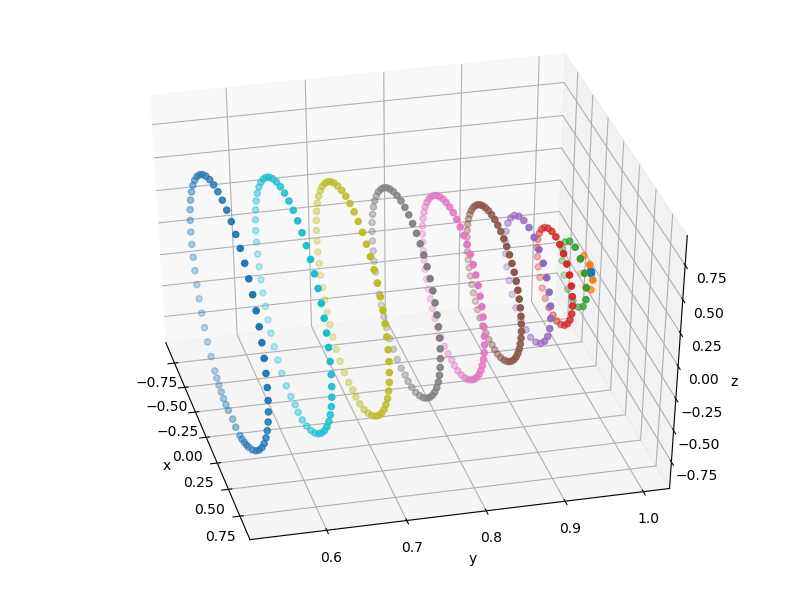

In [55]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111,projection='3d')
for ls in mf.levelsets:
    xs = [point.pos[0] for point in ls.points]
    ys = [point.pos[1] for point in ls.points]
    zs = [point.pos[2] for point in ls.points]
    ax.scatter(xs,ys,zs)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.tight_layout()